In [1]:
import numpy as np
import torch 
import torch.nn as nn
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import os # 
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
bs = 1024
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

## HVAE Architecture

In [3]:
class HVAE(nn.Module):
    def __init__(self, z2_dim, z1_dim):
        super(HVAE, self).__init__()
        ## Encoder 1
        self.e1fc1 = nn.Linear(784, 512)
        self.e1fc2 = nn.Linear(512, 256)
#         self.e1fc3 = nn.Linear(256, 64)
        ## mu1 and logvar1
        self.e1fc4 = nn.Linear(256, z1_dim)
        self.e1fc5 = nn.Linear(256, z1_dim)
        
        ## Encoder 2
        self.e2fc1 = nn.Linear(z1_dim, 256)
        self.e2fc2 = nn.Linear(256, 128)
#         self.e2fc3 = nn.Linear(64, 32)
        ## mu2 and logvar2
        self.e2fc4 = nn.Linear(128, z2_dim)
        self.e2fc5 = nn.Linear(128, z2_dim)
        
        ## Decoder 2
        self.d2fc1 = nn.Linear(z2_dim, 128)
        self.d2fc2 = nn.Linear(128, 256)
#         self.d2fc3 = nn.Linear(128, 256)
        ## d_mu1 and d_logvar1
        self.d2fc4 = nn.Linear(256, z1_dim)
        self.d2fc5 = nn.Linear(256, z1_dim)

        ## Decoder 1
        self.d1fc1 = nn.Linear(z1_dim, 256)
        self.d1fc2 = nn.Linear(256, 512)
#         self.d1fc3 = nn.Linear(128, 256)
        self.d1fc4 = nn.Linear(512, 784)
    
    def encoder1(self, x):
        x = F.relu(self.e1fc1(x))
        x = F.relu(self.e1fc2(x))
#         x = F.relu(self.e1fc3(x))
        
        mu1 = self.e1fc4(x)
        logvar1 = self.e1fc5(x)
        
        return mu1, logvar1

    def encoder2(self, z2):
        z2 = F.relu(self.e2fc1(z2))
        z2 = F.relu(self.e2fc2(z2))
#         z2 = F.relu(self.e2fc3(z2))
        
        mu2 = self.e2fc4(z2)
        logvar2 = self.e2fc5(z2)
        
        return mu2, logvar2

    def r_sampling(self, mu, logvar): 
        epsilon = torch.randn_like(mu)
        var = torch.exp(0.5*logvar)
        z = var.mul(epsilon).add(mu)
        return z, epsilon   

    def decoder2(self, z2):
        z1_rec = F.relu(self.d2fc1(z2))
        z1_rec = F.relu(self.d2fc2(z1_rec))
#         z1_rec = F.relu(self.d2fc3(z1_rec))
        
        d_mu1 = self.d2fc4(z1_rec)
        d_logvar1 = self.d2fc5(z1_rec)
        
        return d_mu1, d_logvar1

    def decoder1(self, z1):
        x_rec = F.relu(self.d1fc1(z1))
        x_rec = F.relu(self.d1fc2(x_rec))
#         x_rec = F.relu(self.d1fc3(x_rec))
        x_rec = self.d1fc4(x_rec)
        return x_rec
    
    def forward(self, x):
        mu1, logvar1 = self.encoder1(x)
        z1, epsilon1 = self.r_sampling(mu1, logvar1)
        mu2, logvar2 = self.encoder2(z1)
        z2, epsilon2 = self.r_sampling(mu2, logvar2)
        d_mu1, d_logvar1 = self.decoder2(z2)
        z1_rec, d_epsilon1 = self.r_sampling(d_mu1, d_logvar1)
        x_rec = self.decoder1(z1)
        
        return x_rec, (mu2, logvar2, epsilon2), (mu1, logvar1, epsilon1), (d_mu1, d_logvar1, d_epsilon1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
import torch.optim as optim

z2_dim = 10
z1_dim = 20

hvae = HVAE(z2_dim, z1_dim).to(device)
optimizer = optim.Adam(hvae.parameters(), lr=1e-4)

## Loss 1: Mathematically Incorrect (Assumed z1, z2 to be indepedent)

In [6]:
## Distribution package 
# In this case z1 and z2 are independent which is wrong

import torch.distributions.normal as normal
import torch.distributions.kl as kl

def vae_loss(x, x_rec, mu2, logvar2, mu1, logvar1):

    REC_ERROR = F.binary_cross_entropy(x_rec, x, reduction='sum')
    KL_DIVERGENCE1 = -0.5*torch.sum(1 + logvar1 - mu1**2 - torch.exp(logvar1))
    KL_DIVERGENCE2 = -0.5*torch.sum(1 + logvar2 - mu2**2 - torch.exp(logvar2))

    return REC_ERROR + KL_DIVERGENCE1 + KL_DIVERGENCE2

## Loss 2: Not working, (gradient exploding) 

In [7]:
## Not working 
## Gradient Exploding, gradients becoming NaN

def vae_new_loss(x, x_rec, mu2, logvar2, mu1, logvar1, d_mu1, d_logvar1):
    
    REC_ERROR = F.binary_cross_entropy(torch.sigmoid(x_rec), x, reduction='sum')    
    
    q_z1_x = normal.Normal(mu1, torch.exp(0.5*logvar1))
    q_z2_z1 = normal.Normal(mu2, torch.exp(0.5*logvar2))
    
    p_z2 = normal.Normal(torch.zeros_like(mu2), torch.ones_like(logvar2))
    p_z1_z2 = normal.Normal(d_mu1, torch.exp(0.5*d_logvar1))
    
    log_q_z1_x = q_z1_x.log_prob(q_z1_x.rsample())
    log_q_z2_z1 = q_z2_z1.log_prob(q_z2_z1.rsample())
    
    log_p_z2 = p_z2.log_prob(p_z2.rsample())
    log_p_z1_z2 = p_z1_z2.log_prob(p_z1_z2.rsample())

    ERROR_TERM2 = torch.mean(torch.sum(log_q_z1_x - log_p_z1_z2, axis=0))
    ERROR_TERM3 = torch.mean(torch.sum(log_q_z2_z1 - log_p_z2, axis=0))
    
    return REC_ERROR + ERROR_TERM2 + ERROR_TERM3

## Loss used to train HAVE (Working !!)

In [8]:
def vae_new_loss2(x, x_rec, z2_var_params, z1_var_params, d_z1_var_params):
    
    """
    Working:
    Expanding the log of Normal distribution and expanding it in terms of z1 and z2
    """
    REC_ERROR = F.binary_cross_entropy(torch.sigmoid(x_rec), x, reduction='sum')    
    
    mu2, logvar2, epsilon2 = z2_var_params
    mu1, logvar1, epsilon1 = z1_var_params
    d_mu1, d_logvar1, d_epsilon1 = d_z1_var_params
    
    log_q_z1_x = torch.sum(-0.5*(epsilon1**2) - 0.5*logvar1, dim=-1)
    log_q_z2_z1 = torch.sum(-0.5*(epsilon2**2) - 0.5*logvar2, dim=-1)
    
    z2 = torch.exp(0.5*logvar2).mul(epsilon2).add(mu2)
    z1 = torch.exp(0.5*logvar1).mul(epsilon1).add(mu1)
    dvar1 = torch.exp(0.5*d_logvar1)
    
    log_p_z2 = torch.sum(-0.5*(z2**2), dim=-1)
    log_p_z1_z2 = torch.sum(-0.5*(((z1-d_mu1)/dvar1)**2) - 0.5*d_logvar1, dim=-1)

    ERROR_TERM2 = torch.mean(torch.sum(log_q_z1_x - log_p_z1_z2, axis=0))
    ERROR_TERM3 = torch.mean(torch.sum(log_q_z2_z1 - log_p_z2, axis=0))
    
    return REC_ERROR + ERROR_TERM2 + ERROR_TERM3

In [9]:
for epoch in range(100):
    total_loss = 0
    for idx, (X, y) in enumerate(train_loader):
        X_p_data = X.view(-1,784).to(device)
        optimizer.zero_grad()
        X_p_x_z, z2_var_params, z1_var_params, d_z1_var_params = hvae(X_p_data)
#         loss = vae_loss(X_p_data, X_p_x_z, mu2, logvar2, mu1, logvar1)
#         loss = vae_new_loss(X_p_data, X_p_x_z, mu2, logvar2, mu1, logvar1, d_mu1, d_logvar1)
        loss = vae_new_loss2(X_p_data, X_p_x_z, z2_var_params, z1_var_params, d_z1_var_params)
        loss.backward()
        optimizer.step()
        total_loss += loss
    total_loss /= (bs*len(train_loader))
    print('Loss for epoch: {} is {}'.format(epoch+1,total_loss))

Loss for epoch: 1 is 425.8547668457031
Loss for epoch: 2 is 221.65821838378906
Loss for epoch: 3 is 206.5829315185547
Loss for epoch: 4 is 202.62615966796875
Loss for epoch: 5 is 198.7300262451172
Loss for epoch: 6 is 193.8489532470703
Loss for epoch: 7 is 189.45469665527344
Loss for epoch: 8 is 185.78221130371094
Loss for epoch: 9 is 181.66383361816406
Loss for epoch: 10 is 176.43724060058594
Loss for epoch: 11 is 169.031982421875
Loss for epoch: 12 is 161.19796752929688
Loss for epoch: 13 is 156.83938598632812
Loss for epoch: 14 is 153.5598907470703
Loss for epoch: 15 is 150.46812438964844
Loss for epoch: 16 is 147.40493774414062
Loss for epoch: 17 is 144.39035034179688
Loss for epoch: 18 is 141.66329956054688
Loss for epoch: 19 is 139.19801330566406
Loss for epoch: 20 is 136.9737548828125
Loss for epoch: 21 is 134.96925354003906
Loss for epoch: 22 is 133.35948181152344
Loss for epoch: 23 is 131.96067810058594
Loss for epoch: 24 is 130.7811737060547
Loss for epoch: 25 is 129.63796997

## Visualizing HAVE 

### Reconstructions

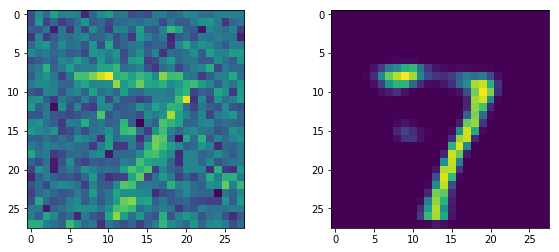

0


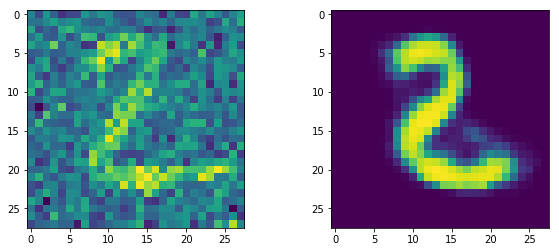

1


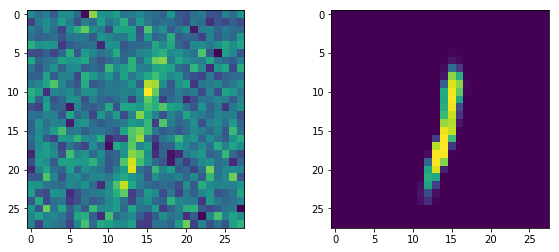

2


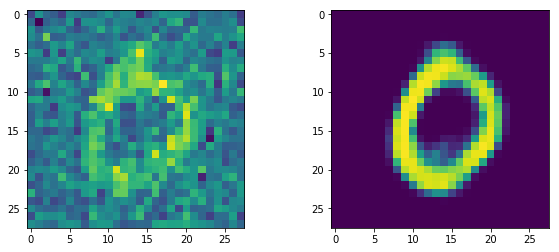

3


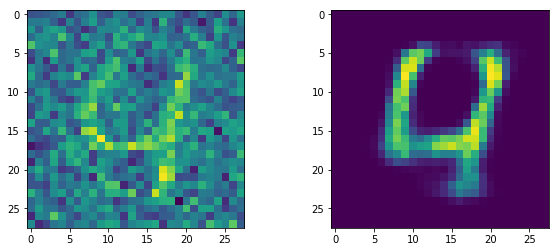

4


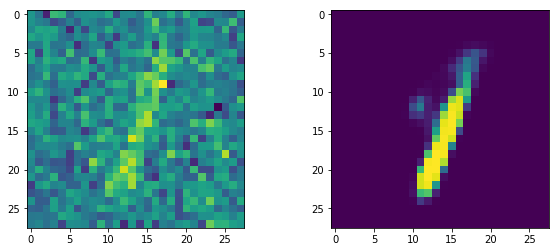

5


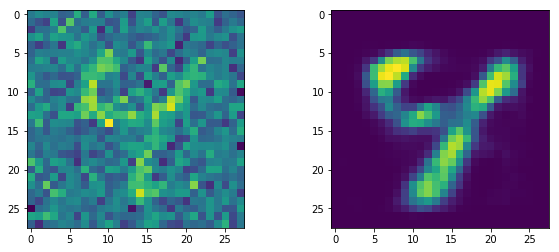

6


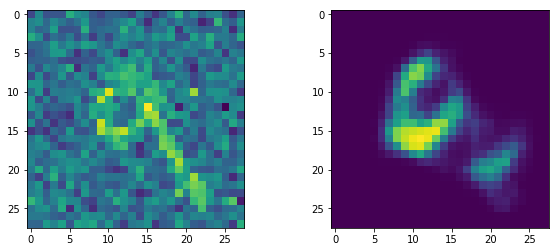

7


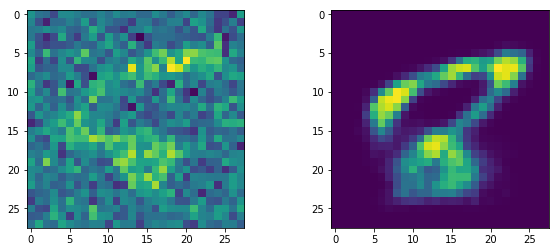

8


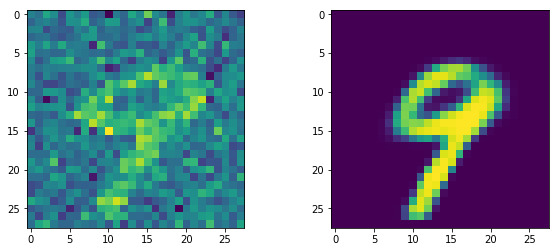

9


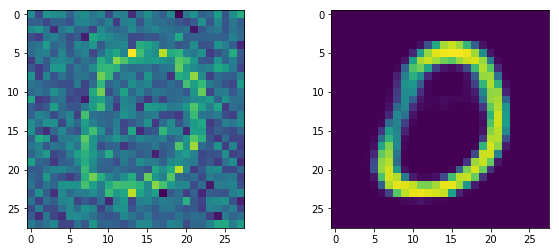

10


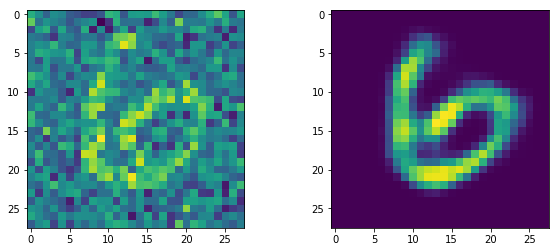

11


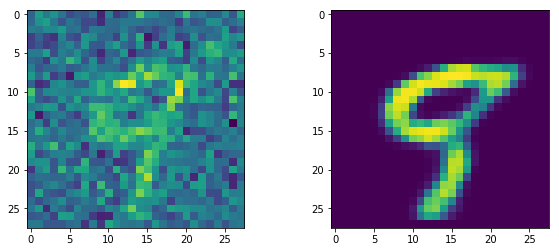

12


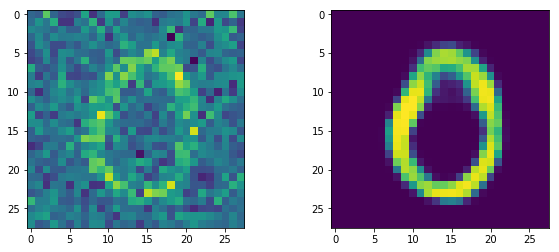

13


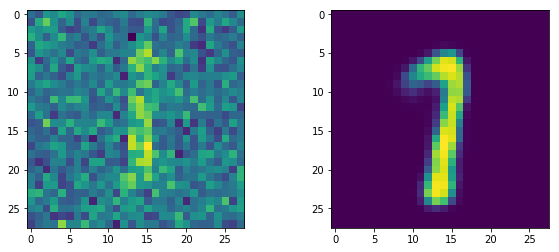

14


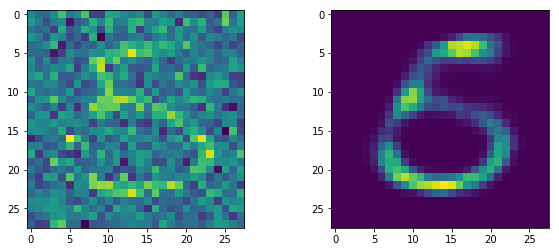

15


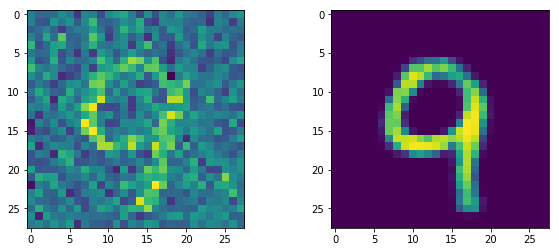

16


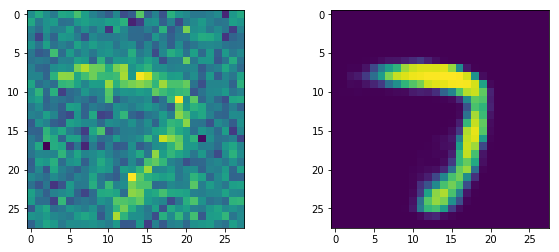

17


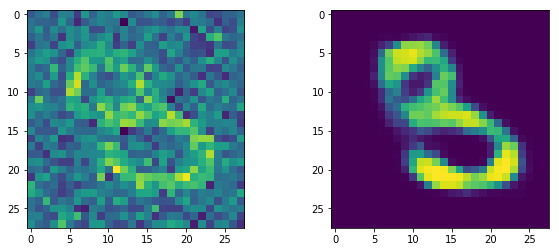

18


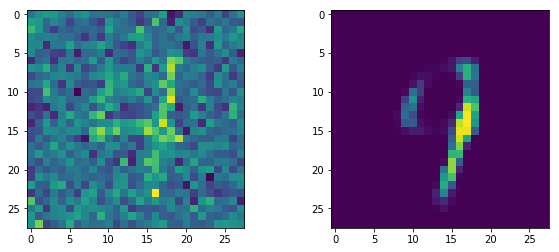

19


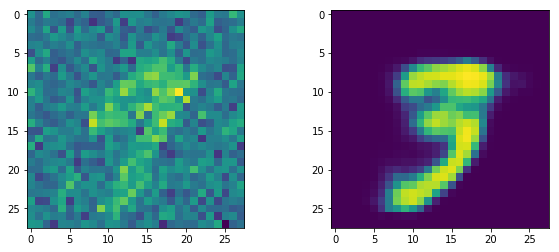

20


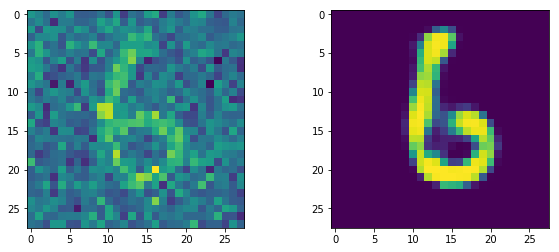

21


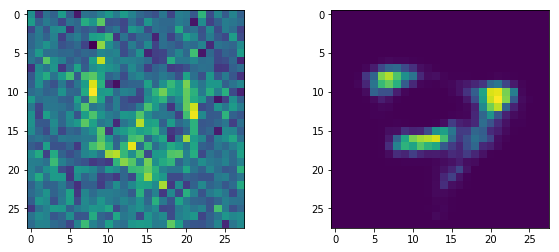

22


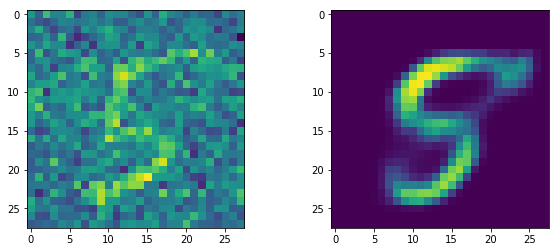

23


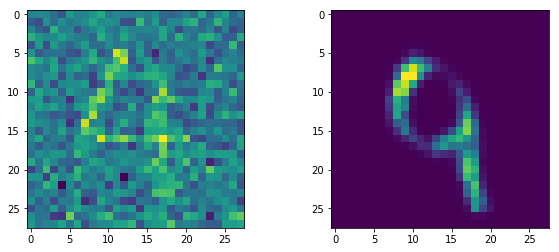

24


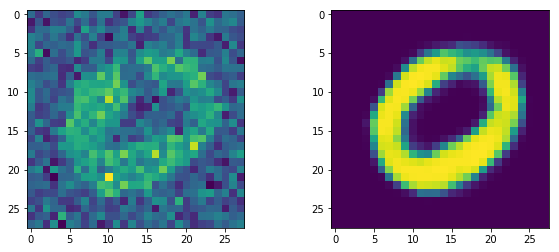

25


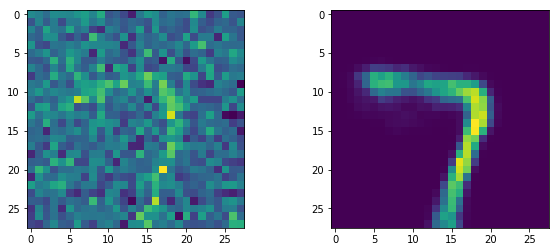

26


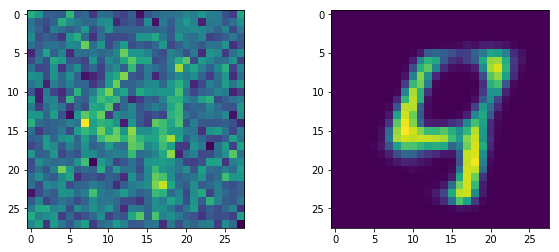

27


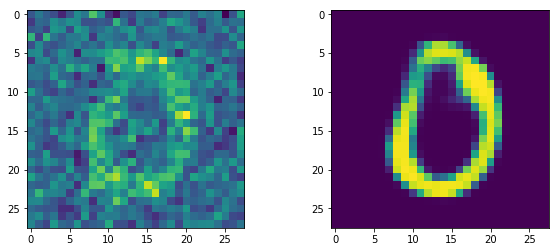

28


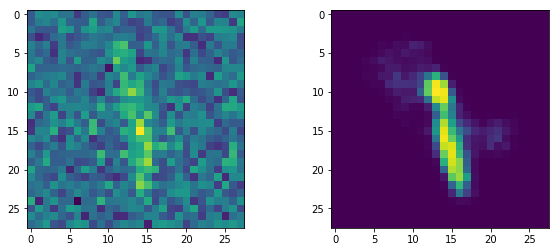

29


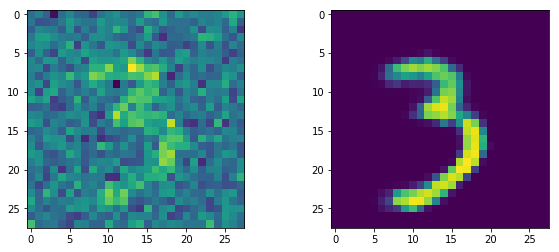

30


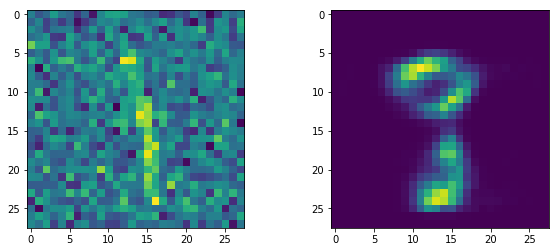

31


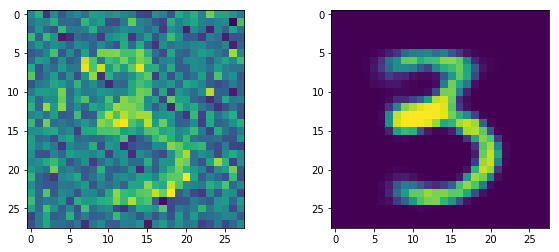

32


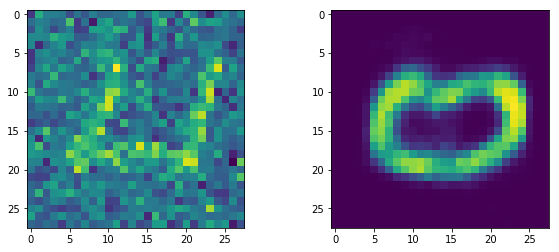

33


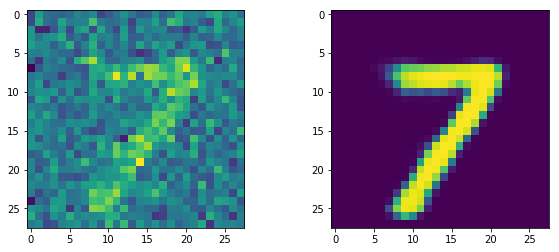

34


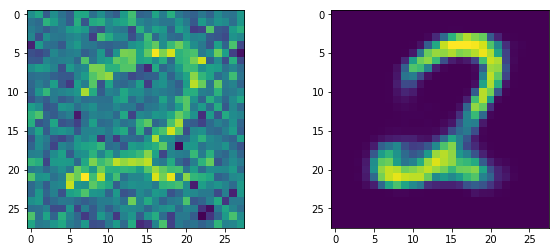

35


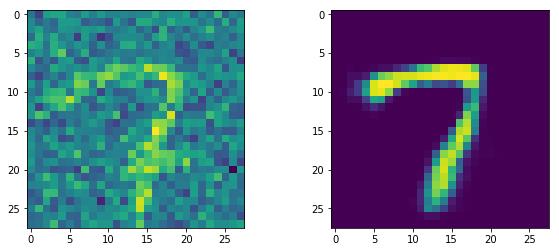

36


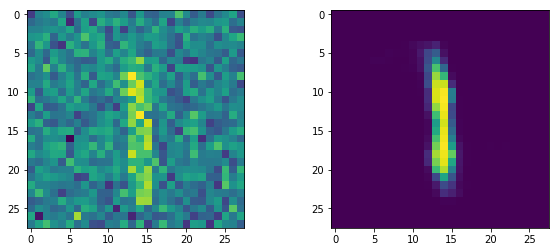

37


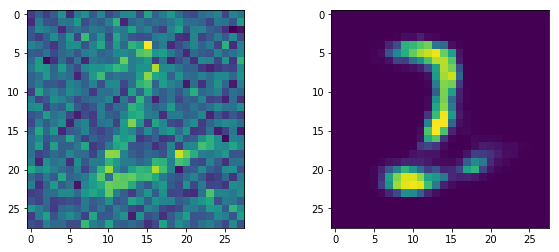

38


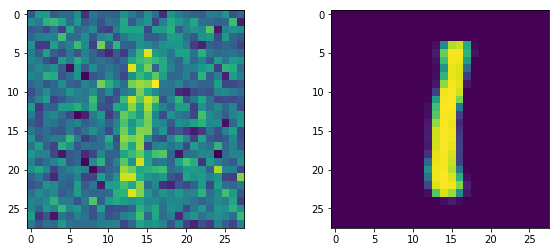

39


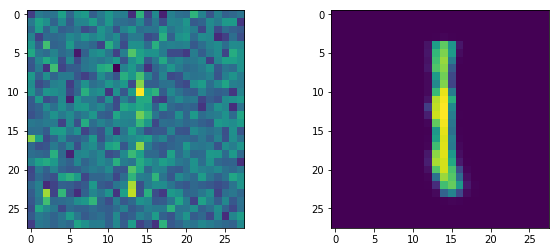

40


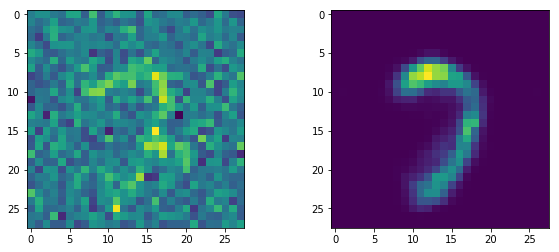

41


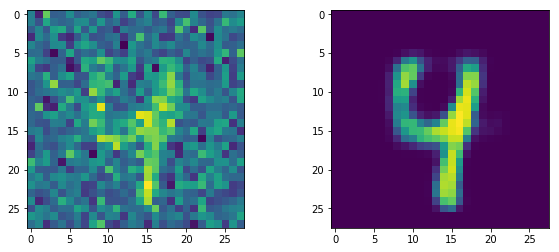

42


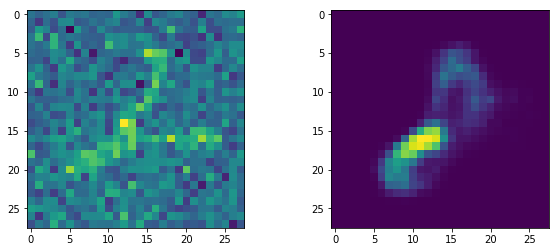

43


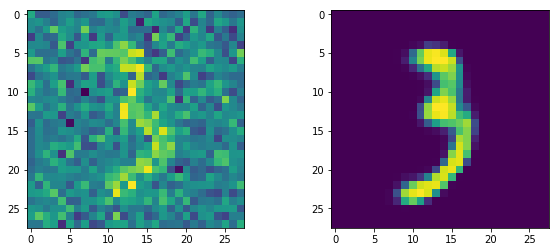

44


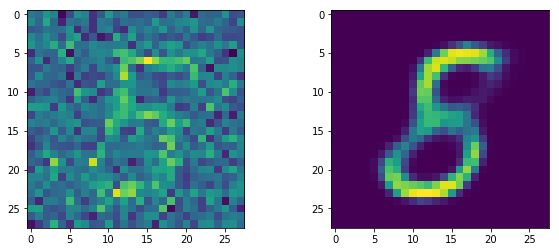

45


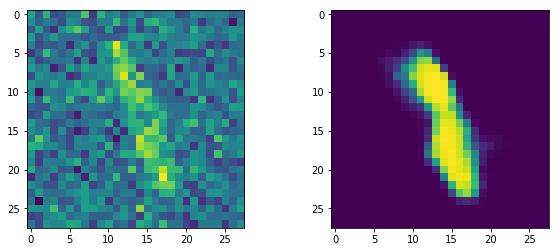

46


KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt 

for test_idx, (X_test, _) in enumerate(test_dataset):    
    x_test_sample = gaussian_noise(X_test[0].view(-1,784), std=0.4)
    x_test_sample = x_test_sample
    x_rec_test_sample = hvae(x_test_sample.to(device))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].imshow(x_test_sample.view(28,28).detach().numpy())
    ax[1].imshow(torch.sigmoid(x_rec_test_sample[0]).cpu().view(28,28).detach().numpy())
#     plt.savefig('./HVAE-Results/Reconstructions/test_reconstruction_{}.png'.format(test_idx))
    plt.show()
    print(test_idx)

### Generation

In [50]:
# Generation from latent space z1 
mu1, logvar1, _ = z1_var_params
gen_q_x_z1 = normal.Normal(mu1, logvar1)
from torchvision.utils import save_image
for i in range(10):
    test_z1_samples = gen_q_x_z1.rsample()
    test_X_gen_z1 = hvae1.decoder1(test_z1_samples)
    save_image(test_X_gen_z1.view(-1, 1, 28, 28), './HVAE-Results/Generation/Latent space z1/z1_generation_{}.png'.format(i))

In [51]:
# Generation from latent space z2 
mu2, logvar2, _ = z2_var_params
# gen_q_z2_z1 = normal.Normal(mu2, logvar2)

from torchvision.utils import save_image
for i in range(10):
    test_z2_samples = torch.randn_like(mu2)
    gen_dmu1, gen_dlogvar1,_ = hvae1.decoder2(z2)
    
#     test_z1_samples = gen_q_x_z1.rsample()
    test_X_gen_z1 = hvae1.decoder1(test_z1_samples)
    save_image(test_X_gen_z1.view(-1, 1, 28, 28), './HVAE-Results/Generation/Latent space z2/z2_generation_{}.png'.format(i))

## Vanilla VAE Architecture

In [69]:
class VAE(nn.Module):
    def __init__(self, z):
        super(VAE, self).__init__()
        self.efc1 = nn.Linear(784, 512)
        self.efc2 = nn.Linear(512, 256)
        
        self.efc3 = nn.Linear(256, z)
        self.efc4 = nn.Linear(256, z)
            
        self.dfc1 = nn.Linear(z, 512)
        self.dfc2 = nn.Linear(512, 256)
        self.dfc3 = nn.Linear(256, 784)
    
    def r_sampling(self, mu, logvar): 
        epsilon = torch.randn_like(mu)
        var = torch.exp(0.5*logvar)
        z = var.mul(epsilon).add(mu)
        return z
        
    def encoder(self, x):
        x = F.tanh(self.efc1(x))
        x = F.tanh(self.efc2(x))
        
        mu = self.efc3(x)
        logvar = self.efc4(x)     
    
        return mu, logvar
    
    def decoder(self, z):
        z = F.tanh(self.dfc1(z))
        z = F.tanh(self.dfc2(z))
        x_rec = self.dfc3(z)
        
        return x_rec
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.r_sampling(mu, logvar)
        x_rec = self.decoder(z)
        
        return x_rec, mu, logvar

In [70]:
z = 15
vae = VAE(z).to(device)

optimizer_vae = optim.Adam(vae.parameters(), lr=1e-3)

In [71]:
def vanilla_vae_loss(x, x_rec, mu, logvar):
    REC_ERROR = F.binary_cross_entropy(torch.sigmoid(x_rec), x, reduction='sum')
    KL_DIVERGENCE = -0.5*torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
    
    return REC_ERROR + KL_DIVERGENCE

In [72]:
def train_vae(epoch):
    total_loss = 0
    for idx, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.view(-1, 784).to(device)
        X_rec, mu, logvar = vae(X_train)
        loss = vanilla_vae_loss(X_train, X_rec, mu, logvar)
        
        optimizer_vae.zero_grad()
        loss.backward()
        optimizer_vae.step()
        
        total_loss += loss.item()
    
    total_loss /= (bs*len(train_loader))
    
    print('For epoch {}, loss is {}'.format(epoch+1, total_loss))

In [73]:
epochs = 200
for e in range(epochs):
    train_vae(e)

/media/data/conda/lsinghal/envs/ls-torch-py35/lib/python3.5/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


For epoch 1, loss is 250.91896975242486
For epoch 2, loss is 200.05279308254435
For epoch 3, loss is 190.96817559711005
For epoch 4, loss is 175.88369000968285
For epoch 5, loss is 158.74609219825874
For epoch 6, loss is 148.97530145160223
For epoch 7, loss is 142.14567889197397
For epoch 8, loss is 136.91365904727223
For epoch 9, loss is 133.0571581307104
For epoch 10, loss is 130.18068113165387
For epoch 11, loss is 127.80255256264897
For epoch 12, loss is 125.54411509885627
For epoch 13, loss is 123.76844878115897
For epoch 14, loss is 122.34921717239638
For epoch 15, loss is 120.99800006413864
For epoch 16, loss is 119.77330870547537
For epoch 17, loss is 118.5911764371193
For epoch 18, loss is 117.64590104959778
For epoch 19, loss is 116.61793815483482
For epoch 20, loss is 115.81942141258111
For epoch 21, loss is 115.09995075807733
For epoch 22, loss is 114.40697479248047
For epoch 23, loss is 113.6635664600437
For epoch 24, loss is 112.96763623771021
For epoch 25, loss is 112.28

## MNIST Classifier Architecture

In [29]:
## MNIST Classifier 

class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1) 
        self.maxpool1 = nn.MaxPool2d(2) # 14x14x32
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.maxpool2 = nn.MaxPool2d(2) # 7x7x64
        
        self.conv3 = nn.Conv2d(64, 16, kernel_size=(3,3), padding=1)
        self.maxpool3 = nn.MaxPool2d(2) # 3x3x16
        
        self.fc1 = nn.Linear(3*3*16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,10)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, bs):
        
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)
        
        x = x.view(-1, 3*3*16)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x        

In [30]:
classifier_mnist = classifier().to(device)

In [31]:
import torch.optim as optim

optimizer_classifier = optim.Adam(classifier_mnist.parameters(), lr=1e-3)

In [32]:
criterion_classifier = nn.CrossEntropyLoss()

In [33]:
def train_classifier(epoch):
    total_loss = 0
    for idx, (X_train, y_train) in enumerate(train_loader):
        y_pred = classifier_mnist(X_train.to(device), bs)
        loss = criterion_classifier(y_pred, y_train.to(device))
        
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()
        total_loss += loss.item()
    print('For epoch {}, loss is {}'.format(epoch, total_loss))

In [34]:
epochs = 20
for e in range(epochs):
    train_classifier(e)

For epoch 0, loss is 77.88350242376328
For epoch 1, loss is 19.411217227578163
For epoch 2, loss is 11.129679836332798
For epoch 3, loss is 7.978466875851154
For epoch 4, loss is 6.357790865004063
For epoch 5, loss is 5.471577733755112
For epoch 6, loss is 4.629725955426693
For epoch 7, loss is 4.131150800734758
For epoch 8, loss is 3.7853078059852123
For epoch 9, loss is 3.4167351946234703
For epoch 10, loss is 3.1416956558823586
For epoch 11, loss is 2.989090858027339
For epoch 12, loss is 2.790146315470338
For epoch 13, loss is 2.832125451415777
For epoch 14, loss is 2.4379459340125322
For epoch 15, loss is 2.298820300027728
For epoch 16, loss is 2.2061316119506955
For epoch 17, loss is 2.173738442361355
For epoch 18, loss is 1.9289890863001347
For epoch 19, loss is 1.9356780052185059


In [35]:
total_correct = 0

for X_test, y_test, in test_loader:
    y_pred_test = classifier_mnist(X_test.to(device), bs) 
    correct = torch.sum((torch.argmax(y_pred_test, axis=1).eq(y_test.to(device)))).item()
    total_correct+=correct
test_accuracy = (total_correct/len(test_loader.dataset))*100
print('Test Accuracy', test_accuracy)

Test Accuracy 98.94


### Gassuain noise function 

In [11]:
import torch.distributions as tdist
def gaussian_noise(input, std=0.2):
    noise = torch.normal(mean=0, std=torch.ones_like(input)*std)
    return input + noise

### Testing HVAE on MNIST with gaussian noise 

In [67]:
hvae.eval()
hvae_total_correct = 0

for hvae_X_test, hvae_y_test, in test_loader:
    hvae_X_test = gaussian_noise(hvae_X_test, std=0.4)
    hvae_X_rec_test, _, _, _ = hvae(hvae_X_test.view(-1,784).to(device))
    hvae_X_rec_test = hvae_X_rec_test.view(-1, 1, 28, 28)
    hvae_X_noise_test = torch.sigmoid(hvae_X_rec_test)
    hvae_y_pred_test = classifier_mnist(hvae_X_noise_test.to(device), bs) 
    hvae_correct = torch.sum((torch.argmax(hvae_y_pred_test, axis=1).eq(hvae_y_test.to(device)))).item()
    hvae_total_correct+=hvae_correct
hvae_test_accuracy = (hvae_total_correct/len(test_loader.dataset))*100
print('Test Accuracy for HVAE', hvae_test_accuracy)

Test Accuracy for HVAE 80.97999999999999


### Testing VAE on MNIST with gaussian noise 

In [76]:
vae.eval()
vae_total_correct = 0

for vae_X_test, vae_y_test, in test_loader:
    vae_X_test = gaussian_noise(vae_X_test, std=0.4)
    vae_X_rec_test, _, _ = vae(vae_X_test.view(-1,784).to(device))
    vae_X_rec_test = vae_X_rec_test.view(-1, 1, 28, 28)
    vae_X_noise_test = torch.sigmoid(vae_X_rec_test)
    vae_y_pred_test = classifier_mnist(vae_X_noise_test.to(device), bs) 
    vae_correct = torch.sum((torch.argmax(vae_y_pred_test, axis=1).eq(vae_y_test.to(device)))).item()
    vae_total_correct+=vae_correct
vae_test_accuracy = (vae_total_correct/len(test_loader.dataset))*100
print('Test Accuracy for VAE', vae_test_accuracy)

/media/data/conda/lsinghal/envs/ls-torch-py35/lib/python3.5/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test Accuracy for VAE 63.49


In [ ]:
# have_y_pred_test = classifier_mnist(have_X_noise_test.to(device), bs) 
# have_correct = torch.sum((torch.argmax(have_y_pred_test, axis=1).eq(have_y_test.to(device)))).item()